# Importing the dependencies

In [2]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pylab as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 15})
import plotly.express as px

# Text Pre-processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from afinn import Afinn
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import coo_matrix

# Model Validation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

#Model Building
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

#Model Accuracy
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix, classification_report

# To save & load models
from pickle import dump
from pickle import load

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Descriptive Statistics

In [3]:
# loading dataset
df = pd.read_excel('hotel_reviews.xlsx')
df.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

In [4]:
# Null Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
# Duplicate Values
df.duplicated().value_counts()

False    20491
dtype: int64

In [6]:
print("Any duplicate reviews:", df[df.duplicated()].shape[0])

Any duplicate reviews: 0


In [7]:
df.describe()

Rating
count  20491.000000
mean       3.952223
std        1.233030
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000

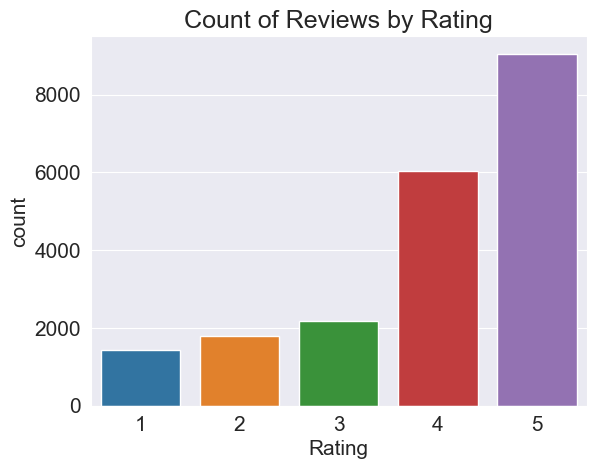

In [8]:
# Most of the rating are in 4 and 5 
sns.countplot(df['Rating']).set(title="Count of Reviews by Rating");

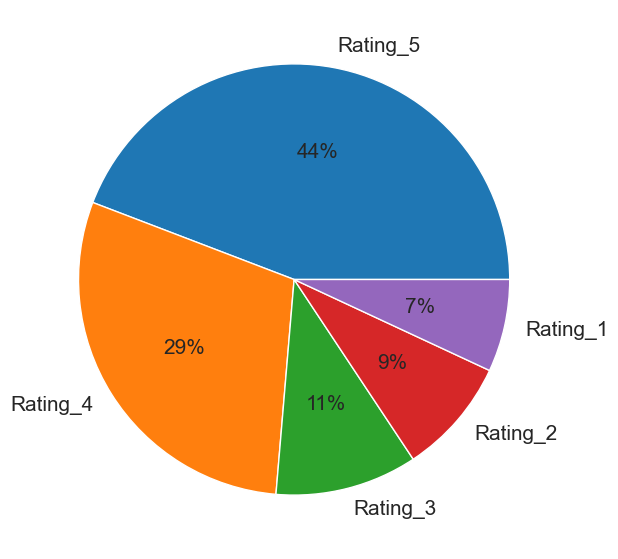

In [9]:
plt.figure(figsize=(15,7))
plt.pie(df['Rating'].value_counts(), labels = ['Rating_5','Rating_4','Rating_3','Rating_2','Rating_1'], autopct='%.0f%%');

In [10]:
# Custom Function to divide the rating into two class problem
def map_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    else:
        return 'Positive'

In [11]:
# sentiment mapped into 2 class 1=Positive reviews 0=Negtaive reviews
df['Sentiment'] = [map_sentiment(x) for x in df['Rating']]
df.head()

Review  Rating Sentiment
0  nice hotel expensive parking got good deal sta...       4  Positive
1  ok nothing special charge diamond member hilto...       2  Negative
2  nice rooms not 4* experience hotel monaco seat...       3  Positive
3  unique, great stay, wonderful time hotel monac...       5  Positive
4  great stay great stay, went seahawk game aweso...       5  Positive

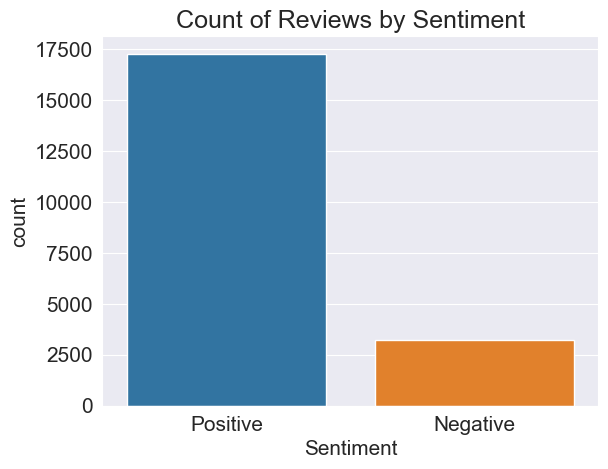

In [12]:
# 1 = Positive; 0 = Negative
sns.countplot(df['Sentiment']).set(title="Count of Reviews by Sentiment");

# Text Data Cleaning

In [13]:
# Lemmatization
wordnet = WordNetLemmatizer()

# Stop word
stop_words = stopwords.words('english')

nlp = spacy.load('en_core_web_sm')

In [14]:
# Varibale created for words which are not included in the stopwords
not_stopwords = ("aren", "aren't", "couldn", "couldn't", "didn", "didn't",
                 "doesn", "doesn't", "don", "don't", "hadn", "hadn't", "hasn",
                 "hasn't", "haven", "haven't", "isn", "isn't", "mustn",
                 "mustn't", "no", "not", "only", "shouldn", "shouldn't",
                 "should've", "wasn", "wasn't", "weren", "weren't", "will",
                 "wouldn", "wouldn't", "won't", "very")
stop_words_ = [words for words in stop_words if words not in not_stopwords]

# Additional words added in the stop word list
# stop_words_.append("I")
# stop_words_.append("the")
stop_words_.append("n")
print(stop_words_)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'own', 'same', 'so', 'than', 'too', 's', 't', 'can'

In [15]:
corpus = []
for i in range(0, len(df)):
    
    # Removal of puntuations
    review = re.sub('[^a-zA-Z0-9*]', ' ', df['Review'][i])
    
    # Converting Text to Lower case
    review = review.lower()

    # Spliting each words - eg ['I','was','happy']
    review = review.split()

    # Applying Lemmitization for the words eg: Argument -> Argue - Using Spacy Library
    review = nlp(' '.join(review))
    review = [token.lemma_ for token in review]

    # Removal of stop words
    review = [word for word in review if word not in stop_words_]

    # Joining the words in sentences
    review = ' '.join(review)
    corpus.append(review)

In [16]:
df['Cleaned_Review'] = corpus

In [17]:
# remove both the leading and the trailing characters
review = [x.strip() for x in df.Cleaned_Review]

# removes empty strings, because they are considered in Python as False
df['Cleaned_Review'] = [x for x in review if x]

In [18]:
df

Review  Rating Sentiment  \
0      nice hotel expensive parking got good deal sta...       4  Positive   
1      ok nothing special charge diamond member hilto...       2  Negative   
2      nice rooms not 4* experience hotel monaco seat...       3  Positive   
3      unique, great stay, wonderful time hotel monac...       5  Positive   
4      great stay great stay, went seahawk game aweso...       5  Positive   
...                                                  ...     ...       ...   
20486  best kept secret 3rd time staying charm, not 5...       5  Positive   
20487  great location price view hotel great quick pl...       4  Positive   
20488  ok just looks nice modern outside, desk staff ...       2  Negative   
20489  hotel theft ruined vacation hotel opened sept ...       1  Negative   
20490  people talking, ca n't believe excellent ratin...       2  Negative   

                                          Cleaned_Review  
0      nice hotel expensive parking get good deal sta...  
1      ok nothing special charge diamond member hilto...  
2      nice room not 4 * experience hotel monaco seat...  
3      unique great stay wonderful time hotel monaco ...  
4      great stay great stay go seahawk game awesome ...  
...                                                  ...  
20486  well keep secret 3rd time stay charm not 5 sta...  
20487  great location price view hotel great quick pl...  
20488  ok look nice modern outside desk staff particu...  
20489  hotel theft ruin vacation hotel open sept 17 2...  
20490  people talk believe excellent rating hotel yes...  

[20491 rows x 4 columns]

In [19]:
# Finding total words in cleaned review
clean_review_words = " ".join(df['Cleaned_Review'])
clean_review_words = clean_review_words.split()

# total number of words present in cleaned reviews
len(clean_review_words)

2121512

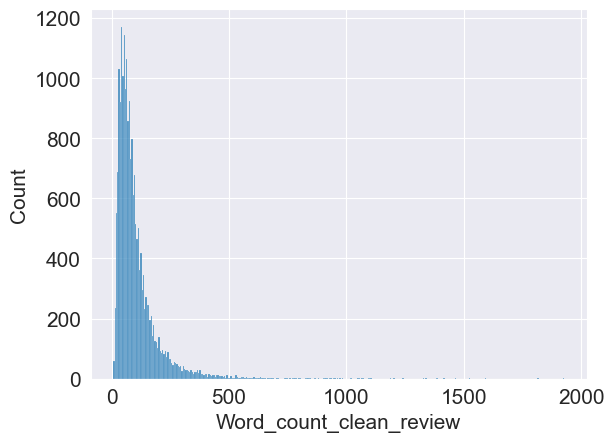

In [20]:
# Number of words in the cleaned Review
df['Word_count_clean_review'] = pd.Series([len(item.split()) for item in df['Cleaned_Review']])

# most of the cleaned review have 20 to 40 words
sns.histplot(df['Word_count_clean_review']);

In [23]:
# finding frequency of all words
all_words = len(clean_review_words)
print('Total words in clean review is {}'.format(all_words))

word_dist = nltk.FreqDist(clean_review_words)

# Creating dataframe for word frequency
freq_data_all = pd.DataFrame(word_dist.most_common(all_words),columns=['Word', 'Frequency'])

# Percentage of word frequency
freq_data_all['percentFreq_all'] = (freq_data_all.Frequency / freq_data_all.Frequency.sum()) * 100

print('No of unique words {}'.format(len(freq_data_all)))
print(freq_data_all[0:10])

Total words in clean review is 2121512
No of unique words 45260
    Word  Frequency  percentFreq_all
0  hotel      53701         2.531261
1   room      47753         2.250895
2    not      34315         1.617478
3   stay      28174         1.328015
4   good      22152         1.044161
5  great      21620         1.019085
6  staff      16792         0.791511
7  night      14546         0.685643
8    day      13458         0.634359
9   nice      13210         0.622669


In [24]:
# words which are used only once 
(freq_data_all['Frequency']==1).value_counts() 

True     23543
False    21717
Name: Frequency, dtype: int64

In [25]:
# Parts Of Speech Tagging for first 1000 reviews
one_block = pd.Series(' '.join(df['Review'][0:1000]))[0]
doc_block = nlp(one_block)
spacy.displacy.render(doc_block, style='ent', jupyter=True)

# Affin Sentiment

In [26]:
afn = Afinn()

In [27]:
# Affin Sentiment Score
score = [afn.score(item) for item in df['Cleaned_Review']]

# Positive review = 1
# Negative review = 0

# Affin Sentiment Making it a two class classification problem
Affin_sentiment = [1 if score > 0 else 0 for score in score]
# Affin_sentiment = ['Positive' if score > 0 else 'Negative' for score in score]
Affin_sentiment_Nue = ['Positive' if score > 0 else 'Nuetral' if score ==0 else 'Negative' for score in score]

In [28]:
# Affin Sentiment & Score added to the data frame
df['Affin_score'] = score
df['Affin_sentiment'] = Affin_sentiment
df['Affin_sentiment_Nue'] = Affin_sentiment_Nue

In [29]:
# viewing only the negative reviews
df[df['Affin_sentiment'] == 0]['Cleaned_Review']
# df[df['Affin_sentiment'] == 'Negative']['Cleaned_Review']

15       horrible customer service hotel stay february ...
42       warwick bad good review warwick shock staff qu...
44       austin power decor familiar hotel seattlewhere...
65       hate inn terrible room service horrible staff ...
76       stay clear internet reservation friday rang ho...
                               ...                        
20421    bad sleep hip tooooo hip nite club building ca...
20465    not stay hotel bring group february bad hotel ...
20467    return la concha nightmare surprising hotel re...
20484    deceptive staff deceptive desk staff claim not...
20489    hotel theft ruin vacation hotel open sept 17 2...
Name: Cleaned_Review, Length: 1699, dtype: object

In [30]:
df.head()

Review  Rating Sentiment  \
0  nice hotel expensive parking got good deal sta...       4  Positive   
1  ok nothing special charge diamond member hilto...       2  Negative   
2  nice rooms not 4* experience hotel monaco seat...       3  Positive   
3  unique, great stay, wonderful time hotel monac...       5  Positive   
4  great stay great stay, went seahawk game aweso...       5  Positive   

                                      Cleaned_Review  Word_count_clean_review  \
0  nice hotel expensive parking get good deal sta...                       84   
1  ok nothing special charge diamond member hilto...                      251   
2  nice room not 4 * experience hotel monaco seat...                      215   
3  unique great stay wonderful time hotel monaco ...                       86   
4  great stay great stay go seahawk game awesome ...                      177   

   Affin_score  Affin_sentiment Affin_sentiment_Nue  
0         26.0                1            Positive  
1         29.0                1            Positive  
2         20.0                1            Positive  
3         38.0                1            Positive  
4         33.0                1            Positive

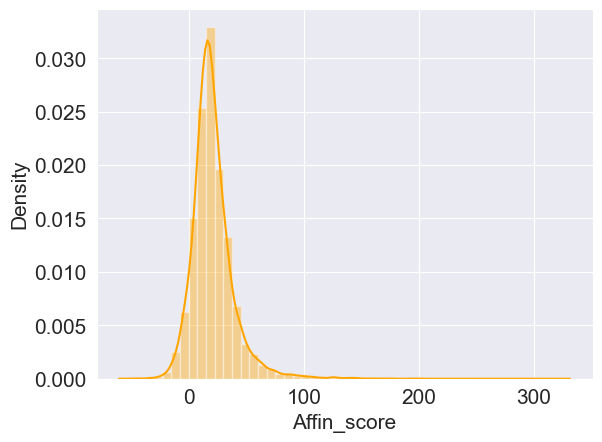

In [31]:
# Affin score visualization
sns.distplot(df['Affin_score'], color='orange');

Class: 1, Number: 18792, Percentage 91.71
Class: 0, Number: 1699, Percentage 8.29


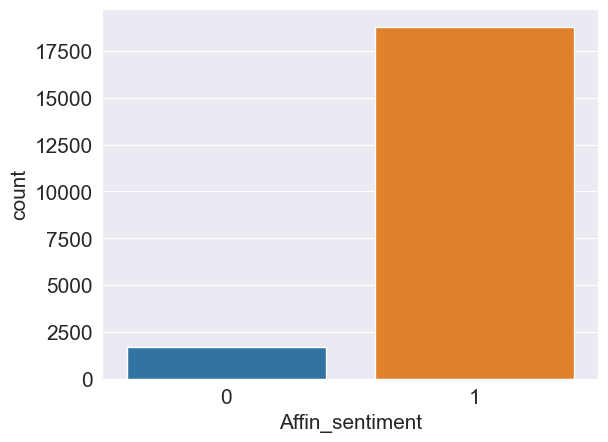

In [32]:
sns.countplot(df['Affin_sentiment'])
counter = Counter(df['Affin_sentiment'])
counter.items()

# Percentage of Data as per Affin Sentiment, Huge diffrence in the two classes..!!
for k, v in counter.items():
    per = v / df.shape[0] * 100
    print("Class: {}, Number: {}, Percentage {}".format(k, v, np.round(per, 2)))

Class: Positive, Number: 18792, Percentage 91.71
Class: Nuetral, Number: 197, Percentage 0.96
Class: Negative, Number: 1502, Percentage 7.33


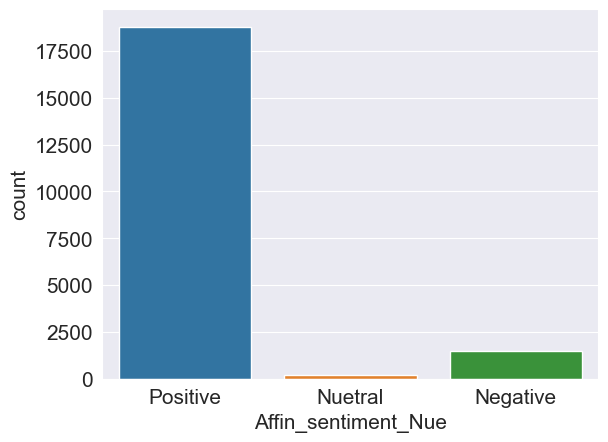

In [33]:
sns.countplot(df['Affin_sentiment_Nue'])
counter = Counter(df['Affin_sentiment_Nue'])
counter.items()

# Percentage of Data as per Affin Sentiment, Huge diffrence in the two classes..!!
for k, v in counter.items():
    per = v / df.shape[0] * 100
    print("Class: {}, Number: {}, Percentage {}".format(k, v, np.round(per, 2)))

In [34]:
polarity = []
subjectivity = []
for i in df['Cleaned_Review']:
    p = TextBlob(i).sentiment.polarity
    s = TextBlob(i).sentiment.subjectivity
    polarity.append(p)
    subjectivity.append(s)

In [35]:
df['polarity'] = polarity
df['subjectivity'] = subjectivity

In [36]:
Polarity_sentiment = [1 if polarity > 0 else 0 for polarity in df['polarity']]
# Polarity_sentiment = ['Positive' if polarity > 0 else 'Negative' for polarity in df['polarity']]
Polarity_sentiment_Nue = ['Positive' if polarity > 0 else 'Nuetral' if polarity ==0 else 'Negative' for polarity in df['polarity']]

In [37]:
df['Polarity_sentiment'] = Polarity_sentiment
df['Polarity_sentiment_Nue'] = Polarity_sentiment_Nue

In [38]:
df.head()

Review  Rating Sentiment  \
0  nice hotel expensive parking got good deal sta...       4  Positive   
1  ok nothing special charge diamond member hilto...       2  Negative   
2  nice rooms not 4* experience hotel monaco seat...       3  Positive   
3  unique, great stay, wonderful time hotel monac...       5  Positive   
4  great stay great stay, went seahawk game aweso...       5  Positive   

                                      Cleaned_Review  Word_count_clean_review  \
0  nice hotel expensive parking get good deal sta...                       84   
1  ok nothing special charge diamond member hilto...                      251   
2  nice room not 4 * experience hotel monaco seat...                      215   
3  unique great stay wonderful time hotel monaco ...                       86   
4  great stay great stay go seahawk game awesome ...                      177   

   Affin_score  Affin_sentiment Affin_sentiment_Nue  polarity  subjectivity  \
0         26.0                1            Positive  0.187495      0.665455   
1         29.0                1            Positive  0.187337      0.503035   
2         20.0                1            Positive  0.302032      0.617442   
3         38.0                1            Positive  0.532870      0.712963   
4         33.0                1            Positive  0.401786      0.614796   

   Polarity_sentiment Polarity_sentiment_Nue  
0                   1               Positive  
1                   1               Positive  
2                   1               Positive  
3                   1               Positive  
4                   1               Positive

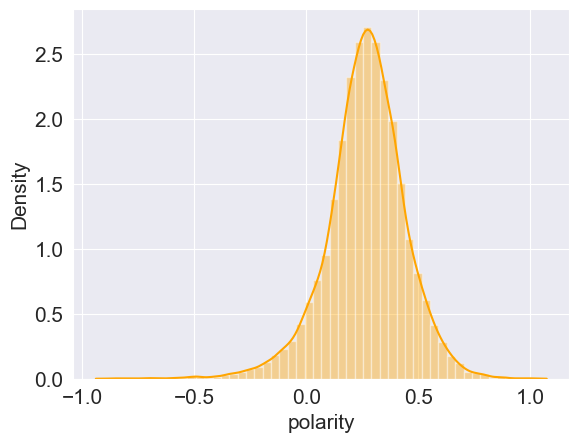

In [39]:
# Polarity score visualization
sns.distplot(df['polarity'], color='orange');

Class: 1, Number: 19150, Percentage 93.46
Class: 0, Number: 1341, Percentage 6.54


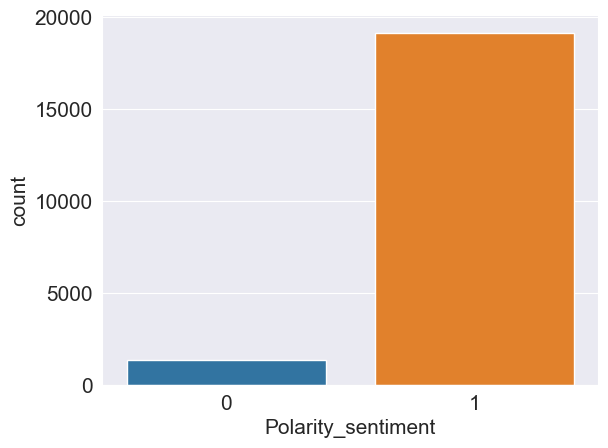

In [40]:
sns.countplot(df['Polarity_sentiment'])
counter = Counter(df['Polarity_sentiment'])
counter.items()

# Percentage of Data as per polarity Sentiment, Huge diffrence in the two classes..!!
for k, v in counter.items():
    per = v / df.shape[0] * 100
    print("Class: {}, Number: {}, Percentage {}".format(k, v, np.round(per, 2)))

Class: Positive, Number: 19150, Percentage 93.46
Class: Negative, Number: 1323, Percentage 6.46
Class: Nuetral, Number: 18, Percentage 0.09


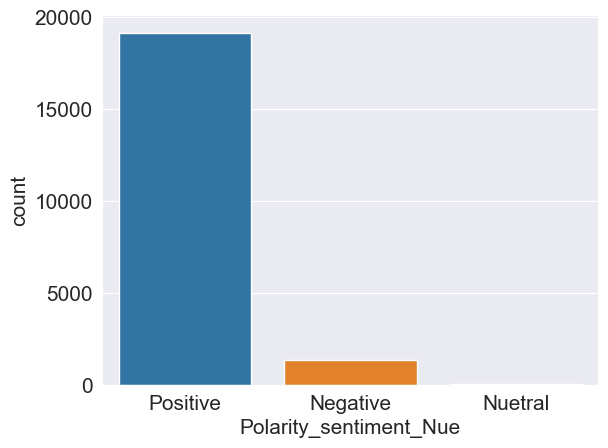

In [41]:
sns.countplot(df['Polarity_sentiment_Nue'])
counter = Counter(df['Polarity_sentiment_Nue'])
counter.items()

# Percentage of Data as per polarity Sentiment, Huge diffrence in the two classes..!!
for k, v in counter.items():
    per = v / df.shape[0] * 100
    print("Class: {}, Number: {}, Percentage {}".format(k, v, np.round(per, 2)))

In [42]:
# Comparison for Affin and Polarity Sentiments
pd.crosstab(df['Affin_sentiment'], df['Polarity_sentiment'], normalize='all')

Polarity_sentiment         0         1
Affin_sentiment                       
0                   0.049876  0.033039
1                   0.015568  0.901518

# Vader Sentiment

In [43]:
sid_obj = SentimentIntensityAnalyzer()
vader = []
for i in df['Cleaned_Review']:
    v = sid_obj.polarity_scores(i)
    v_compound = v['compound']
    vader.append(v_compound)
df['vader'] = vader
vader_sentiment = [1 if vader > 0 else 0 for vader in df['vader']]
# vader_sentiment = ['Positive' if vader > 0 else 'Negative' for vader in df['vader']]
vader_sentiment_Nue = ['Positive' if vader > 0 else 'Nuetral' if vader ==0 else 'Negative' for vader in df['vader']]
df['vader_sentiment'] = vader_sentiment
df['vader_sentiment_Nue'] = vader_sentiment_Nue
df.head()

Review  Rating Sentiment  \
0  nice hotel expensive parking got good deal sta...       4  Positive   
1  ok nothing special charge diamond member hilto...       2  Negative   
2  nice rooms not 4* experience hotel monaco seat...       3  Positive   
3  unique, great stay, wonderful time hotel monac...       5  Positive   
4  great stay great stay, went seahawk game aweso...       5  Positive   

                                      Cleaned_Review  Word_count_clean_review  \
0  nice hotel expensive parking get good deal sta...                       84   
1  ok nothing special charge diamond member hilto...                      251   
2  nice room not 4 * experience hotel monaco seat...                      215   
3  unique great stay wonderful time hotel monaco ...                       86   
4  great stay great stay go seahawk game awesome ...                      177   

   Affin_score  Affin_sentiment Affin_sentiment_Nue  polarity  subjectivity  \
0         26.0                1            Positive  0.187495      0.665455   
1         29.0                1            Positive  0.187337      0.503035   
2         20.0                1            Positive  0.302032      0.617442   
3         38.0                1            Positive  0.532870      0.712963   
4         33.0                1            Positive  0.401786      0.614796   

   Polarity_sentiment Polarity_sentiment_Nue   vader  vader_sentiment  \
0                   1               Positive  0.9626                1   
1                   1               Positive  0.9829                1   
2                   1               Positive  0.9936                1   
3                   1               Positive  0.9945                1   
4                   1               Positive  0.9897                1   

  vader_sentiment_Nue  
0            Positive  
1            Positive  
2            Positive  
3            Positive  
4            Positive

In [44]:
# Comparison for Affin and Vader Sentiments
pd.crosstab(df['Affin_sentiment'], df['vader_sentiment'], normalize='all')

vader_sentiment         0         1
Affin_sentiment                    
0                0.056073  0.026841
1                0.015470  0.901615

In [45]:
# Comparison for Polarity and Vader Sentiments
pd.crosstab(df['Polarity_sentiment'], df['vader_sentiment'], normalize='all')

vader_sentiment            0         1
Polarity_sentiment                    
0                   0.046313  0.019130
1                   0.025231  0.909326

# Visualization

## Most Used Words

In [46]:
# Review
mostUsedWords = df['Review'].str.split(expand=True).stack().value_counts()
mostUsedWords_top200 = mostUsedWords[:200]

fig = px.treemap(mostUsedWords_top200, path=[mostUsedWords_top200.index], values=0)
fig.update_layout(title_text='The 200 Most Frequest Words',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

In [47]:
# Cleaned Review
mostUsedWords = df['Cleaned_Review'].str.split(expand=True).stack().value_counts()
mostUsedWords_top200 = mostUsedWords[:200]

fig = px.treemap(mostUsedWords_top200, path=[mostUsedWords_top200.index], values=0)
fig.update_layout(title_text='The 200 Most Frequest Words',
                  title_x=0.5, title_font=dict(size=20)
                  )
fig.update_traces(textinfo="label+value")
fig.show()

# Word Cloud

## Word cloud for Entire Reviews

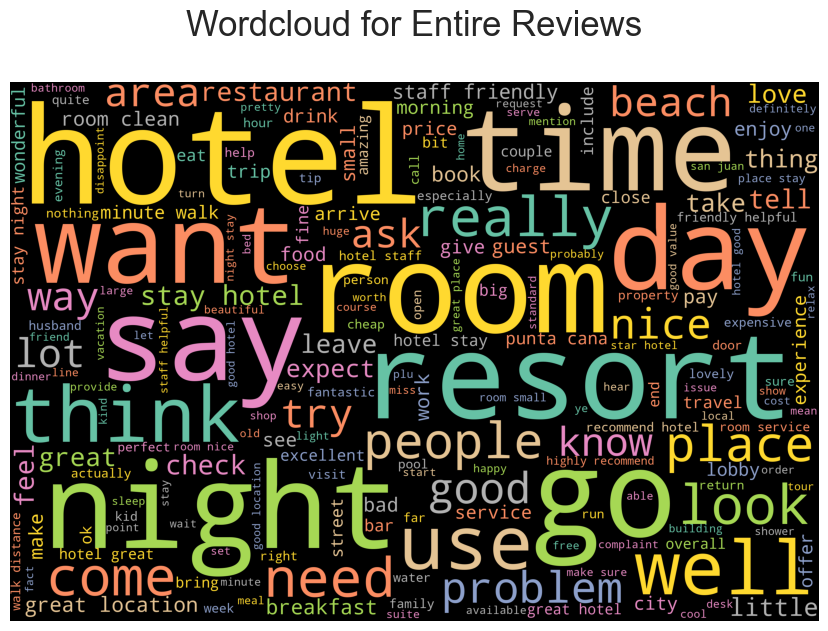

In [48]:
wordcloud = WordCloud(width=3000,
                      height=2000,
                      background_color='Black',
                      colormap='Set2',
#                       stopwords=stop_words_,
#                       max_words=1000,
                      random_state=42,
                      max_font_size = 500
                     ).generate(str(corpus))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Wordcloud for Entire Reviews", y=1.07, fontsize=25)
plt.show()

## Word Cloud for Positive Reviews

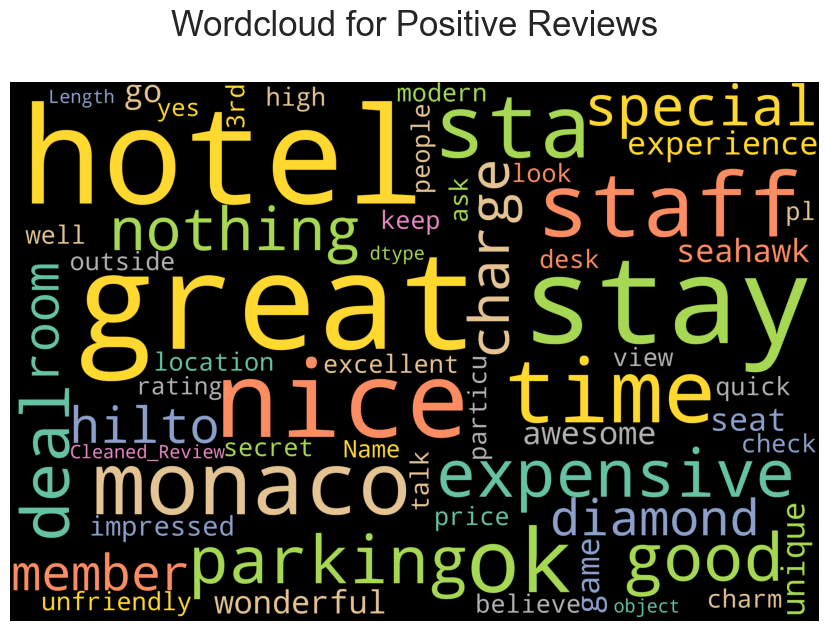

In [49]:
wordcloud = WordCloud(width=3000,
                      height=2000,
                      background_color='Black',
                      colormap='Set2',
#                       stopwords=stop_words_,
#                       max_words=100,
                      random_state=42,
                      max_font_size = 500
                      ).generate(str(df[df['Affin_sentiment'] == 1]['Cleaned_Review']))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Wordcloud for Positive Reviews", y=1.07, fontsize=25)
plt.show()

## Word Cloud for Negative Reviews

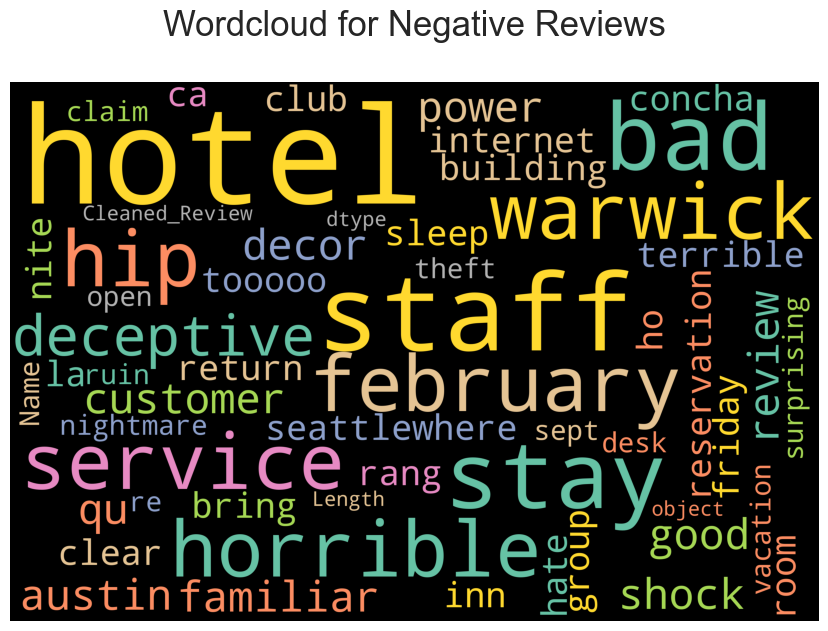

In [50]:
wordcloud = WordCloud(width=3000,
                      height=2000,
                      background_color='Black',
                      colormap='Set2',
#                       stopwords=stop_words_,
#                       max_words=100,
                      random_state=42,
                      max_font_size = 500
                     ).generate(str(df[df['Affin_sentiment'] == 0]['Cleaned_Review']))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Wordcloud for Negative Reviews", y=1.07, fontsize=25)
plt.show()

# Term Frequency with Count Vetorizer

In [51]:
# Stop word
stop_words_keywords = stopwords.words('english')

# special additioanl stop words added for keyword extraction
stop_words_keywords.extend(["will", "always", "go", "one", "very", "good", "only", "mr", "lot", "two",
                            "th", "etc", "don", "due", "didn", "since", "nt", "ms", "ok", "almost",
                            "put", "pm", "hyatt", "grand", "till", "add", "let", "hotel", "able",
                            "per", "st", "couldn", "yet", "par", "hi", "well", "would", "I", "the",
                            "s", "also", "great", "get", "like", "take", "thank"
                            ])

## Unigram

<AxesSubplot:title={'center':'Unigram Frequency'}>

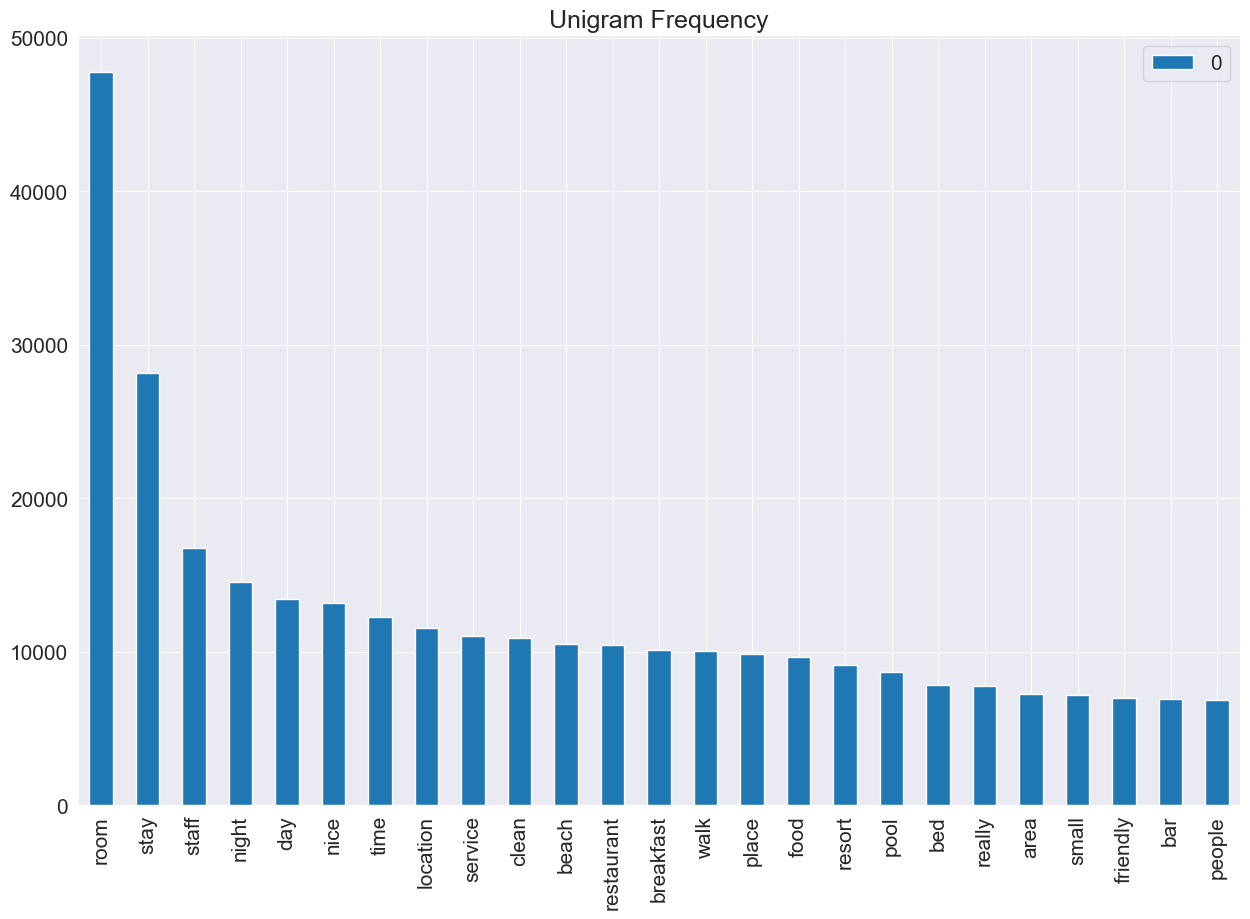

In [52]:
# find the most frequent words in the data, extracting information about its content and topics.
stops = set(stopwords.words('english') + ['com'])
co = CountVectorizer(stop_words=stop_words_keywords)
counts = co.fit_transform(corpus)
most_freq_terms = pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0, ascending=False).head(25)
most_freq_terms.plot(kind='bar', title='Unigram Frequency', figsize=(15, 10))

## Bi-Grams

<AxesSubplot:title={'center':'bi-grams'}>

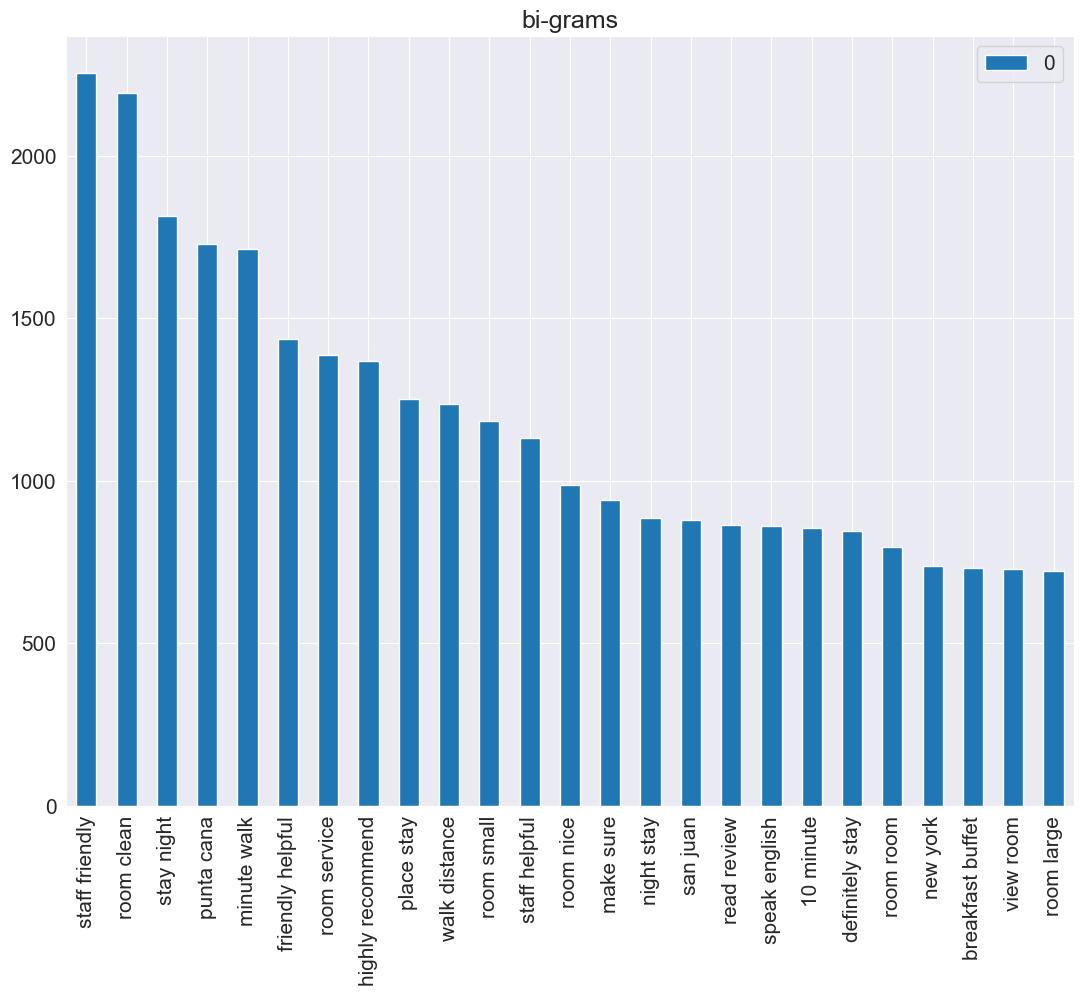

In [53]:
# Now we can check for frequent bi-grams:
co = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words_keywords)
counts1 = co.fit_transform(corpus)
bi_grams = pd.DataFrame(counts1.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0, ascending=False).head(25)
bi_grams.plot(kind='bar', title='bi-grams', figsize=(13, 10))

## Tri-Grams

<AxesSubplot:title={'center':'tri-grams'}>

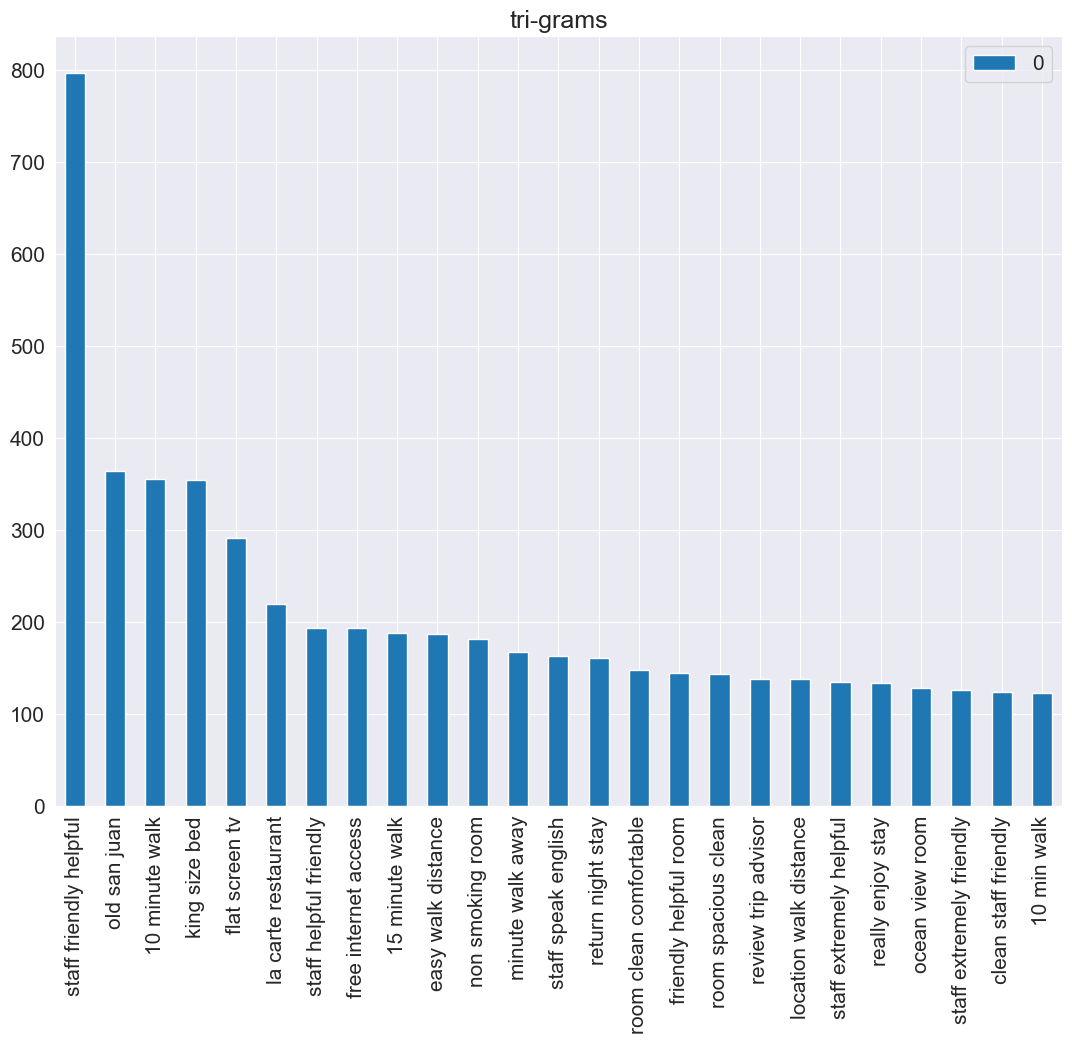

In [54]:
# Now we can check for frequent tri-grams:
co = CountVectorizer(ngram_range=(3, 3), stop_words=stop_words_keywords)
counts1 = co.fit_transform(corpus)
tri_grams = pd.DataFrame(counts1.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0, ascending=False).head(25)
tri_grams.plot(kind='bar', title='tri-grams', figsize=(13, 10))

# Term Frequency with TFIDF 

## Unigram

<AxesSubplot:title={'center':'most frequent terms & their frequency'}>

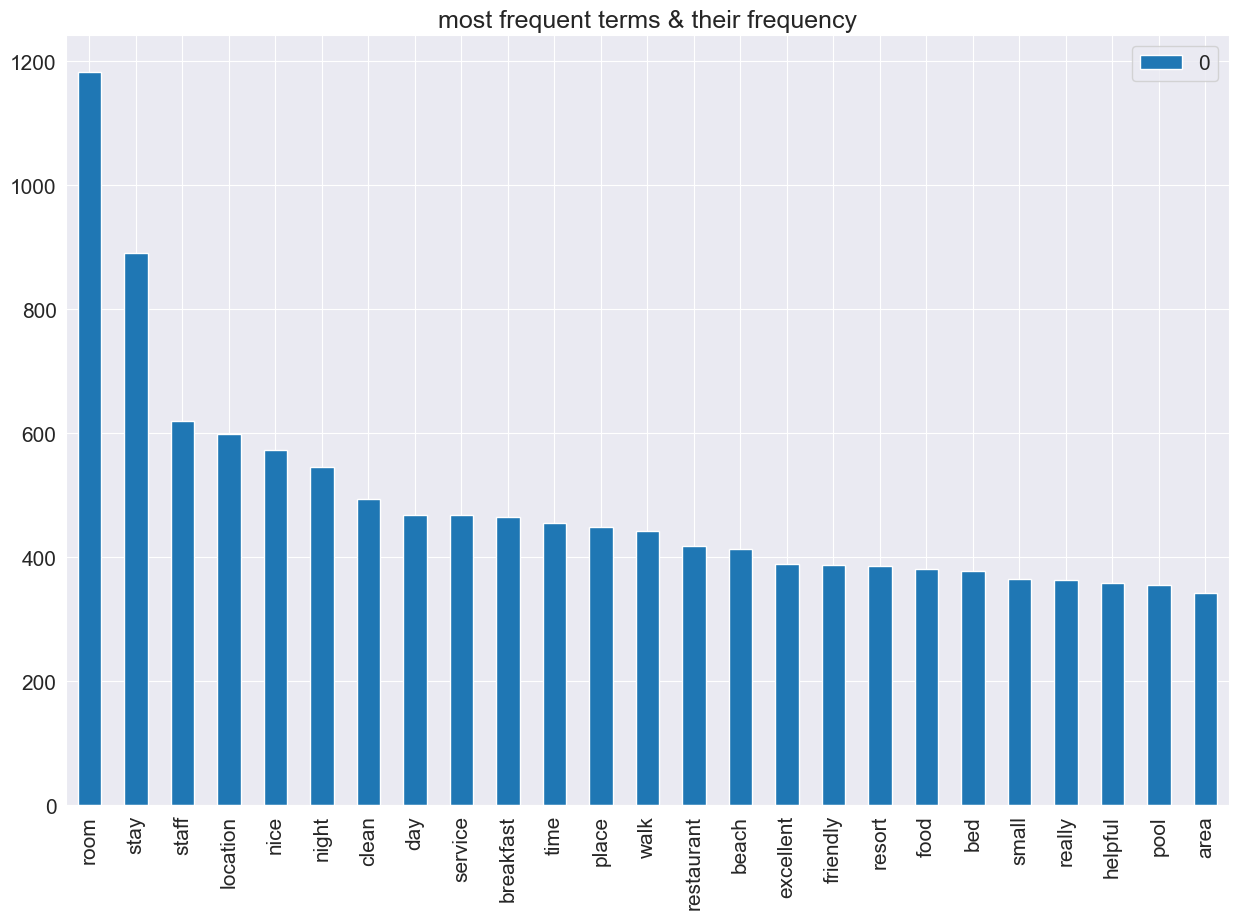

In [55]:
# Converting text into vectors by TFIDF
tfidf2 = TfidfVectorizer(norm="l2",analyzer='word', stop_words=stop_words_keywords,ngram_range=(1,1))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(tfidf2_x.sum(axis=0),columns=tfidf2.get_feature_names()).T.sort_values(0, ascending=False).head(25)
most_freq_terms.plot(kind='bar',title='most frequent terms & their frequency',figsize=(15, 10))

## Bi-Grams

<AxesSubplot:title={'center':'Bi-Gram'}>

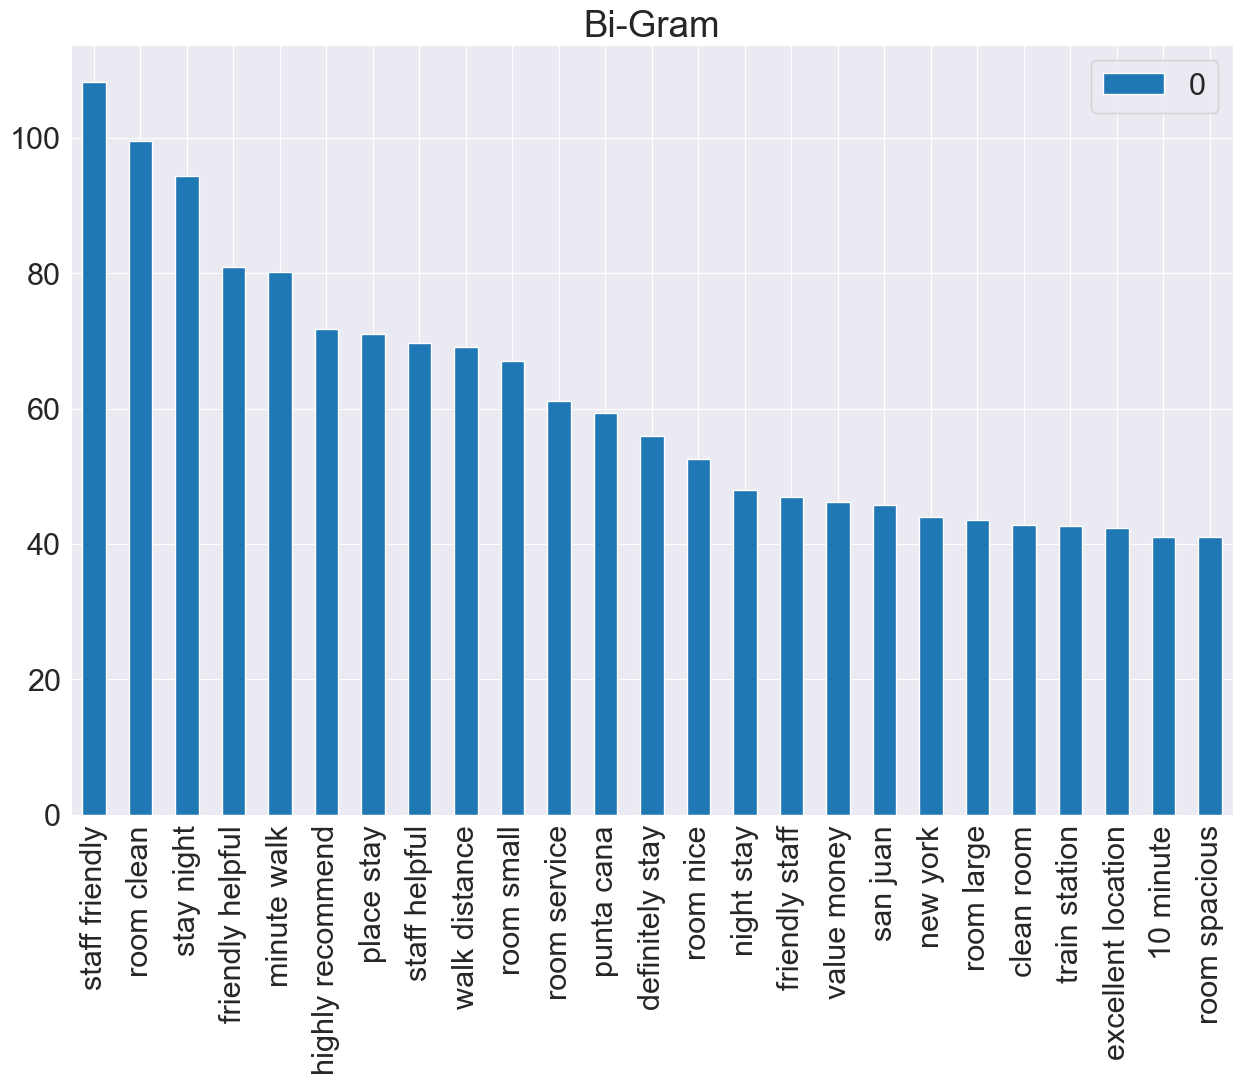

In [56]:
# Now we can check for frequent bi-grams:

tfidf2 = TfidfVectorizer(norm="l2",analyzer='word',stop_words=stop_words_keywords,ngram_range=(2, 2))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(tfidf2_x.sum(axis=0),columns=tfidf2.get_feature_names()).T.sort_values(0,ascending=False).head(25)
plt.rcParams.update({'font.size': 22})
most_freq_terms.plot(kind='bar', title='Bi-Gram', figsize=(15, 10))

## Tri-Grams

<AxesSubplot:title={'center':'Tri-Gram'}>

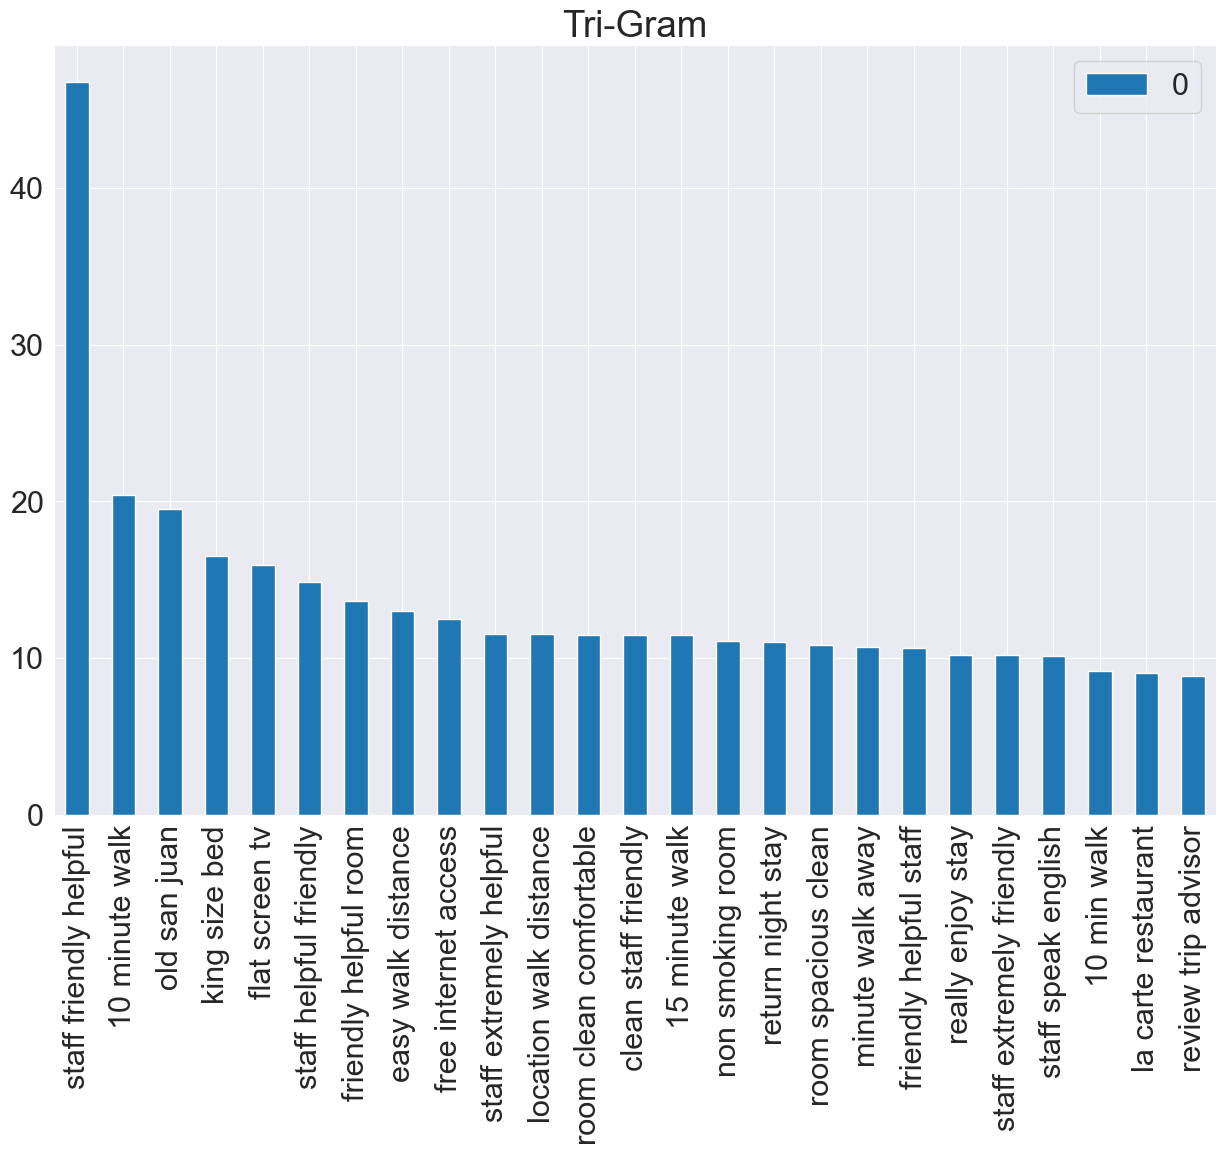

In [57]:
# Now we can check for frequent tri-grams:

tfidf2 = TfidfVectorizer(norm="l2",analyzer='word',stop_words=stop_words_keywords,ngram_range=(3, 3))
tfidf2_x = tfidf2.fit_transform(corpus)
most_freq_terms = pd.DataFrame(tfidf2_x.sum(axis=0),columns=tfidf2.get_feature_names()).T.sort_values(0,ascending=False).head(25)
plt.rcParams.update({'font.size': 22})
most_freq_terms.plot(kind='bar', title='Tri-Gram', figsize=(15, 10))


# Important Attribute Extraction from the Reviews


In [58]:
#Function for sorting tf_idf in descending order
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

# CountVectorizer

In [59]:
cv2 = CountVectorizer(stop_words=stop_words_keywords,ngram_range=(2,2))
cv2_x = cv2.fit_transform(corpus)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(cv2_x)

# get feature names
feature_names = cv2.get_feature_names()

# fetch document for which keywords needs to be extracted
doc = corpus[7]

# generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(cv2.transform([doc]))
#sort the tf-idf vectors by descending order of scores
sorted_items = sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords = extract_topn_from_vector(feature_names,sorted_items,10)

# now print the results
print("\nSentence:")
print(doc)
print("\nAttribute:")
for k in keywords:
    print(k,keywords[k])


Sentence:
excellent staff housekeeping quality hotel chock staff make feel home experience exceptional service desk staff concierge door man maid service need work maid fail tuck sheet foot bed instance soil sheet use staff quickley resolve soil sheet issue guess relate employee not reflection rest staff receive excellent advice concierge regard resturant area happy hour wine taste nice touch staff go way make feel home great location like close good food shopping take play 5th street theather well pike market pioneer square access mono rail short walking distance

Attribute:
soil sheet 0.258
feel home 0.151
make feel 0.14
tuck sheet 0.129
theather pike 0.129
street theather 0.129
staff quickley 0.129
square access 0.129
shopping play 0.129
sheet issue 0.129


# TFIDG

In [60]:
tfidf2 = TfidfVectorizer(norm="l2",analyzer='word', stop_words=stop_words_keywords,ngram_range=(2,2))
tfidf2_x = tfidf2.fit_transform(corpus)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(tfidf2_x)

# get feature names
feature_names = tfidf2.get_feature_names()

# fetch document for which keywords needs to be extracted
doc = corpus[14]

# generate tf-idf for the given document
tf_idf_vector = tfidf_transformer.transform(tfidf2.transform([doc]))
#sort the tf-idf vectors by descending order of scores
sorted_items = sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords = extract_topn_from_vector(feature_names,sorted_items,10)

# now print the results
print("\nSentence:")
print(doc)
print("\nAttribute:")
for k in keywords:
    print(k,keywords[k])


Sentence:
great hotel night quick business trip love little touch like goldfish leopard print robe complaint wifi complimentary not internet access business center great location library service fabulous

Attribute:
wifi complimentary 0.285
touch goldfish 0.285
print robe 0.285
goldfish leopard 0.285
complaint wifi 0.285
location library 0.263
library service 0.263
robe complaint 0.248
leopard print 0.248
quick business 0.227


# Feature extraction by converting text in vector by using TFIDF

In [61]:
tfidf = TfidfVectorizer(max_features=3000,ngram_range=(3,3))
# tfidf = TfidfVectorizer()
# TFIDF for X-train
corpus_tfidf= tfidf.fit_transform(corpus)
corpus_tfidf

# save the model to disk
filename = 'model_TFIDF.sav'
dump(tfidf, open('model_TFIDF.sav', 'wb'))

### X and Y Variable

In [62]:
# Creation of X and Y variable
x = corpus_tfidf
y = df['Affin_sentiment']

# Handling imbalanced data

. We will have to handling the imbalanced data set by using SMOTE Technique

<AxesSubplot:xlabel='Affin_sentiment', ylabel='count'>

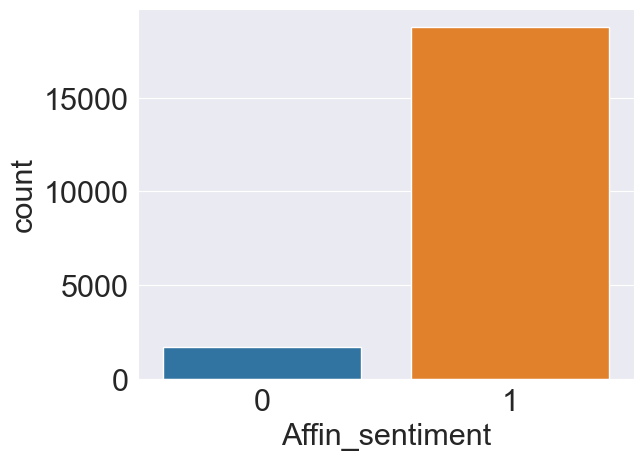

In [63]:
# visualization of the imbalanced Y variable
sns.countplot(y)

<AxesSubplot:xlabel='Affin_sentiment', ylabel='count'>

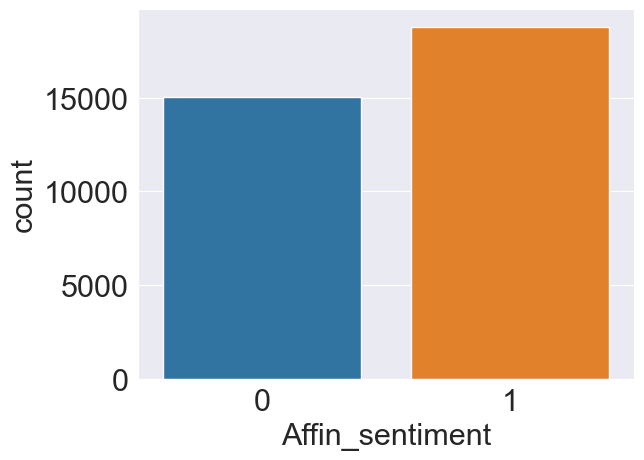

In [64]:
# the minority class will over sampled by 80%
strategy = 0.8

# initializing of SMOTE Sampling
over = SMOTE(sampling_strategy = strategy, random_state=7)
# Over Samplled X and Y variable 
x_over, y_over = over.fit_resample(x, y)
sns.countplot(y_over)

# Split the Data into Train and Test

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, random_state=7, test_size=0.20, stratify=y_over)
print("x_train = {}".format(x_train.shape))
print("x_test = {}".format(x_test.shape))
print("y_train = {}".format(y_train.shape))
print("y_test = {}".format(y_test.shape))

x_train = (27060, 3000)
x_test = (6765, 3000)
y_train = (27060,)
y_test = (6765,)


# Model Building

In [66]:
# custom Fuction to run the model with confusion matrix + Train and test accuracy + F1score
def model_metric(x_train, x_test, y_train, y_test, model, name):

    # predicted for X_train and X_test
    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)

    # Accuracy
    accuracy_train = model.score(x_train, y_train)
    accuracy_test = model.score(x_test, y_test)

    # F1score
    f1_score = metrics.f1_score(y_train, predict_train)

    print('Accuracy for Train set {}'.format(accuracy_train))
    print('Accuracy for Test set {}'.format(accuracy_test))
    print('Fi Score {}'.format(f1_score))
    
    print(classification_report(y_test, predict_test))

    plot_confusion_matrix(estimator=model,X=x_test,y_true=y_test,cmap='Blues')
    plt.grid(False)
    plt.title('{} - Confusion Matrix on Test set'.format(name))

## Logistic Regression

In [67]:
# Grid Creation
Grid = dict()
Grid['C'] = (0.001, 0.01, 0.1, 0.18, 0.2, 1,5)
Grid['penalty'] = ("l1", "l2", "elasticnet")

# K-fold
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# Model
model = LogisticRegression()

# Setting Grid search Cv
search = GridSearchCV(model, Grid, cv=cv)

# Fitting the Cv to train and test
search.fit(x_train, y_train)

print('Best Param - {}'.format(search.best_params_))
print('Best Score - {}'.format(search.best_score_))

Best Param - {'C': 5, 'penalty': 'l2'}
Best Score - 0.8689578713968957


Accuracy for Train set 0.8985587583148559
Accuracy for Test set 0.8724316334072432
Fi Score 0.902372230323292
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      3007
           1       0.95      0.81      0.88      3758

    accuracy                           0.87      6765
   macro avg       0.88      0.88      0.87      6765
weighted avg       0.88      0.87      0.87      6765



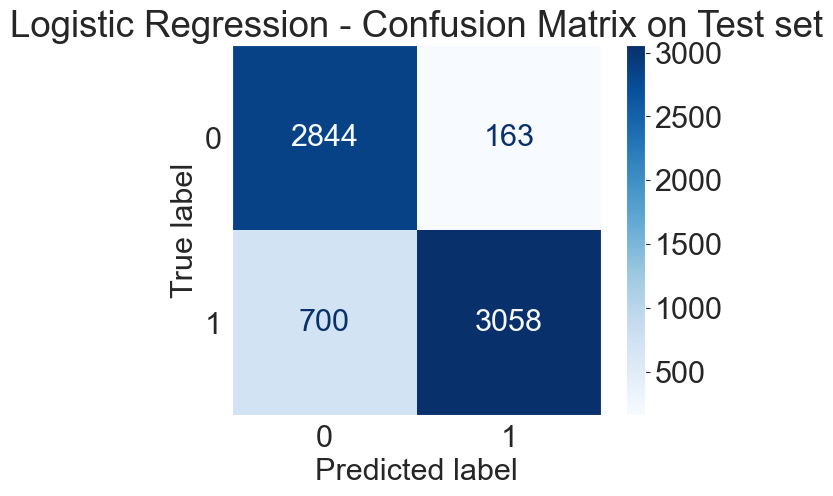

In [68]:
# from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(C=5, penalty='l2', random_state=7)
model_lr.fit(x_train, y_train)

lr_model_output = model_metric(x_train, x_test, y_train, y_test, model_lr, 'Logistic Regression')
lr_model_output

## Naive Bayes

Accuracy for Train set 0.7439024390243902
Accuracy for Test set 0.7238728750923873
Fi Score 0.7934549356223175
              precision    recall  f1-score   support

           0       0.76      0.55      0.64      3007
           1       0.71      0.86      0.78      3758

    accuracy                           0.72      6765
   macro avg       0.73      0.71      0.71      6765
weighted avg       0.73      0.72      0.72      6765



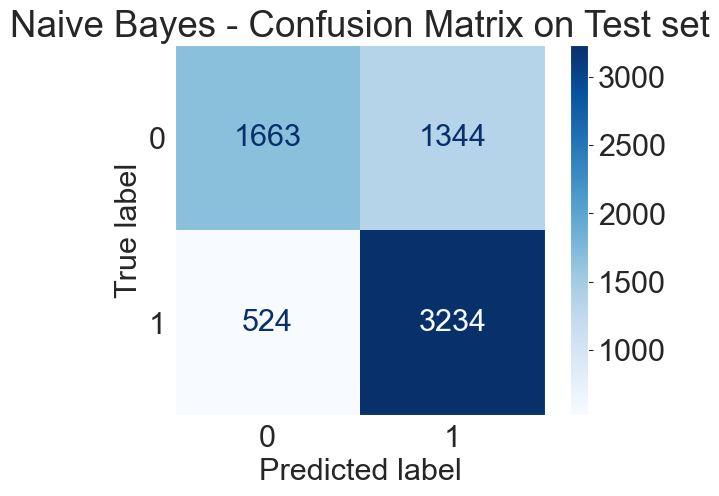

In [69]:
model_naive = MultinomialNB()
model_naive.fit(x_train, y_train)

#Results
model_metric(x_train, x_test, y_train, y_test, model_naive, "Naive Bayes")

## K-Nearest Neighbour

In [70]:
# Grid Creation
Grid = dict()
Grid['n_neighbors'] = range(2,10)

# K-fold
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# Model
model = KNeighborsClassifier()

# Setting Grid search Cv
search = GridSearchCV(model, Grid, cv=cv)

# Fitting the Cv to train and test
search.fit(x_train, y_train)

print('Best Param - {}'.format(search.best_params_))
print('Best Score - {}'.format(search.best_score_))

Best Param - {'n_neighbors': 2}
Best Score - 0.5925720620842572


Accuracy for Train set 0.636659275683666
Accuracy for Test set 0.5818181818181818
Fi Score 0.5215106093050418
              precision    recall  f1-score   support

           0       0.52      0.97      0.67      3007
           1       0.92      0.27      0.42      3758

    accuracy                           0.58      6765
   macro avg       0.72      0.62      0.55      6765
weighted avg       0.74      0.58      0.53      6765



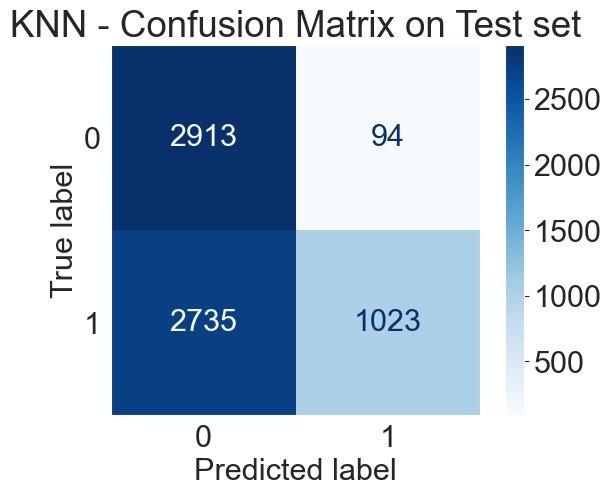

In [71]:
model_knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
model_knn.fit(x_train, y_train)
model_metric(x_train, x_test, y_train, y_test, model_knn, 'KNN')

## Random Forest

In [72]:
# Grid creation
Grid = dict()
Grid['n_estimators'] = (10, 100, 1000)
Grid['max_depth'] = (3, 7, 9, 15, 24)
Grid['max_features'] = ("auto", "sqrt", "log2")

# K-fold
cv = KFold(n_splits=5, shuffle=True, random_state=7)

# define models
model = RandomForestClassifier()

# Setting Grid Search CV
search = GridSearchCV(model, Grid, cv=cv)

# Fitting tthe cv to train and test
search.fit(x_train, y_train)

print('Best Param - {}'.format(search.best_params_))
print('Best Score - {}'.format(search.best_score_))

Best Param - {'max_depth': 24, 'max_features': 'sqrt', 'n_estimators': 10}
Best Score - 0.6439393939393939


Accuracy for Train set 0.6507760532150776
Accuracy for Test set 0.637250554323725
Fi Score 0.7593215158924205
              precision    recall  f1-score   support

           0       0.88      0.21      0.34      3007
           1       0.61      0.98      0.75      3758

    accuracy                           0.64      6765
   macro avg       0.74      0.59      0.55      6765
weighted avg       0.73      0.64      0.57      6765



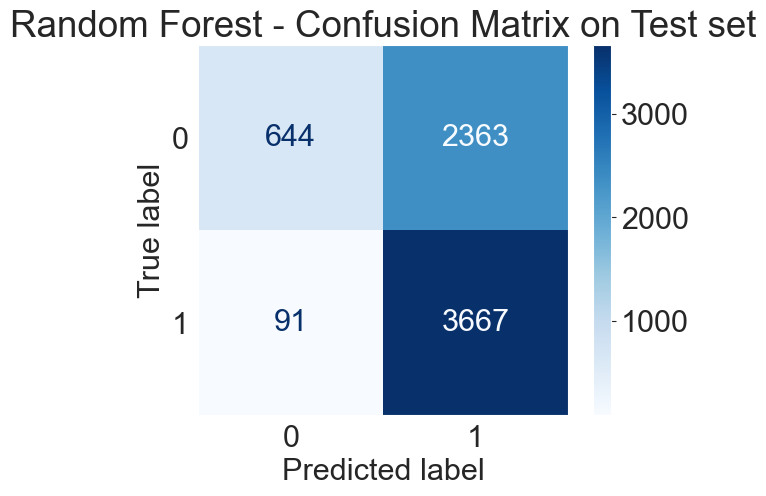

In [73]:
# define models and parameters
num_trees = 1000
model = RandomForestClassifier(n_estimators=num_trees, max_features='auto',max_depth=24)
model.fit(x_train, y_train)

#Results
model_metric(x_train,x_test,y_train,y_test,model, 'Random Forest')